# Домашнее задание 9

Это домашнее задание по материалам 12го семинара. Дедлайн по отправке - 23:55 5 мая. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_9

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from time import time 
from tqdm import trange
from sys import stdout
from sklearn.datasets import load_svmlight_file

## Задача 1

Рассмотрим одномерную задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}} f(x) = x \arctan x - \frac{1}{2} \log (1 + x^2).
\end{equation}

__(а)__ Реализуйте для этой задачи метод градиентного спуска и метод Ньютона. Нарисуйте графики сходимости данных методов для двух разных точек старта $x^0 = 1.3$ и $x^0 = 1.5$. Сделайте вывод. В общем случае для каких $x^0$ еще есть сходимость метода Ньютона, а для каких она пропадает? Почему?

In [68]:
def f(x):
    return x * np.arctan(x) - np.log(1 + x**2) / 2

In [69]:
def grad_f(x):
    return np.arctan(x)

In [70]:
def GD(x_0, gamma, max_iter):
    x = x_0
    error = []
    for i in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f(x)
        x -= grad * gamma
        error.append(grad**2)
    return error, x

In [71]:
def NewTon(x_0, max_iter):
    x = x_0
    error = []
    for i in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f(x)
        x -= grad * (1 + x**2)
        error.append(grad**2)
    return error, x

100%|███████████████████████████████████████████████████| 10/10 [00:00<?, ?it/s]


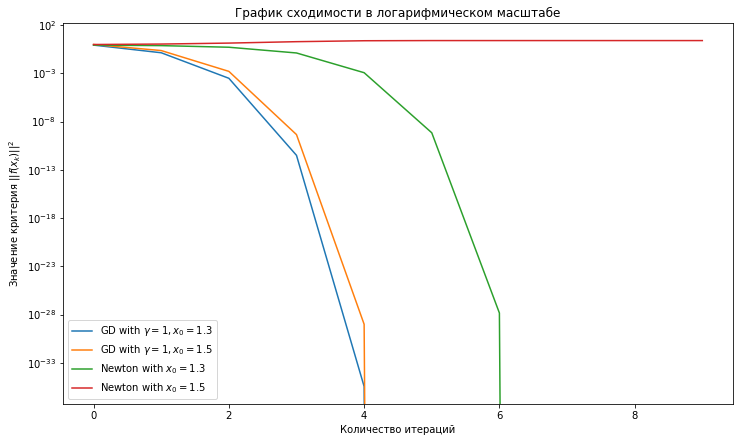

In [72]:
fig = plt.figure(figsize = (12, 7))
error1, _ = GD(1.3, 1, 10)
error2, _ = GD(1.5, 1, 10)
error3, _ = NewTon(1.3, 10)
error4, _ = NewTon(1.5, 10)
plt.plot(range(len(error1)), error1, label = r'GD with $\gamma = 1, x_0 = 1.3$')
plt.plot(range(len(error2)), error2, label = r'GD with $\gamma = 1, x_0 = 1.5$')
plt.plot(range(len(error3)), error3, label = r'Newton with $x_0 = 1.3$')
plt.plot(range(len(error4)), error4, label = r'Newton with $x_0 = 1.5$')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Количество итераций")
plt.ylabel(r"Значение критерия $||f(x_k)||^2$")
plt.yscale('log')
plt.legend()
plt.show()

Как видно из графиков, для метода Ньютона сходимость отсутствует при $x^0 = 1.5$ и присутствует при $x^0 = 1.3$. Условие на сходимость метода Ньютона имеет вид:
$$ ||x - x^*|| \leq \frac{\mu ^ 2}{M_2^2}, $$
где $M_2^2 - $ константа липшица гессиана, а $\mu - $ константа сильной выпуклости функции.

В нашем случае: $M_2 = 1$, а $\mu$ оценивается минимумом второй производной на отрезке. Имеем:
$$x = f''(x) = \frac{1}{1 + x^2}$$ откуда получится $x \le 0.68233...$ - область сходимости.

Но теперь надо вспомнить, что это достаточное условие, а не необходимое, поэтому вот тут при $x_0 = 1.3$ сошлось, а при $x_0 = 1.5$ - нет. В простом виде для данного метода необходимого условия не существует(насколько я знаю).

__(б)__ Реализуйте две модификации метода Ньютона: демпфированный (добавление шага) и кубический метод Ньютона (смотри [статью](https://link.springer.com/article/10.1007/s10107-006-0706-8)). Решают ли эти методы проблему сходимости метода Ньютона для стартовой точки $x^0 = 1.5$? В демпфированном методе попробуйте разные стратегии подбора шага: увеличивающийся, Армихо и другие.

In [73]:
def dempf_newton(x_0, max_iter, rule):
    error = []
    x = x_0
    for i in range(max_iter):
        grad = grad_f(x)
        hessian = 1 / (1 + x ** 2)
        error.append(grad ** 2)
        
        if rule == "grow":
            gamma = 1 - np.exp(- (1 + i))
        
        if rule == "armijo":
            gamma = 1
            pho = 0.9
            c = 1 / 4
            while not f(x - gamma / hessian * grad) <= f(x) - c * gamma * grad * (grad / hessian):
                gamma = gamma * pho
            
        if rule == "wolf":
            gamma = 1
            rho = 0.8
            c1 = 0.01
            c2 = 0.9
            while not (f(x - gamma / hessian * grad) <= f(x) + c1 * gamma * (1 / hessian * grad * grad)) and \
                    abs(grad_f(x - gamma / hessian * grad) * (1 / hessian * grad)) >= c2 * 1 / hessian * grad * grad:
                gamma = gamma * rho 
        x -= gamma / hessian * grad
    return error, x

In [74]:
def cubic_newton(x_0, max_iter):
    error = []
    x = x_0
    for _ in range(max_iter):
        grad = grad_f(x)
        error.append(grad ** 2)
        M = 3 * np.sqrt(3) / 8
        y_r = 5
        y_l = -5
        for _ in range(50):
            y = (y_r + y_l) / 2
            deriv = np.arctan(x) + (y - x) / (1 + x ** 2) + M / 2 * np.sign(y - x) * (y - x) ** 2
            if (deriv == 0):
                x = y
            elif (deriv > 0):                
                y_r = y
                x = (y_r + y_l) / 2
            else:
                y_l = y
                x = (y_r + y_l) / 2
    return error, x

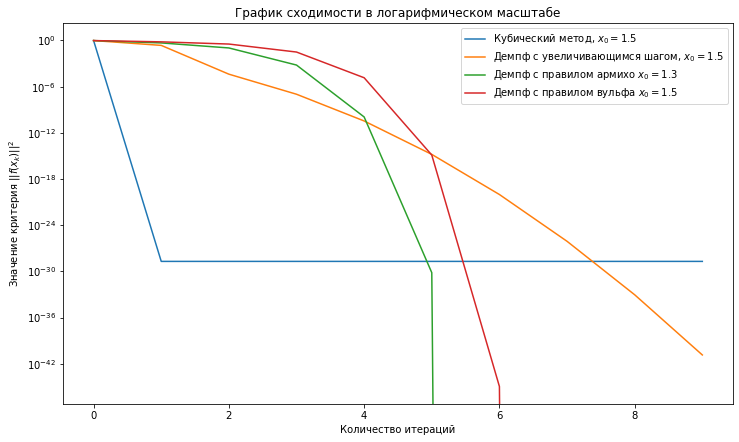

In [75]:
fig = plt.figure(figsize = (12, 7))
error1, _ = cubic_newton(1.5, 10)
error2, _ = dempf_newton(1.5, 10, "grow")
error3, _ = dempf_newton(1.5, 10, "armijo")
error4, _ = dempf_newton(1.5, 10, "wolf")
plt.plot(range(len(error1)), error1, label = r'Кубический метод, $x_0 = 1.5$')
plt.plot(range(len(error2)), error2, label = r'Демпф с увеличивающимся шагом, $x_0 = 1.5$')
plt.plot(range(len(error3)), error3, label = r'Демпф с правилом армихо $x_0 = 1.3$')
plt.plot(range(len(error4)), error4, label = r'Демпф с правилом вульфа $x_0 = 1.5$')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Количество итераций")
plt.ylabel(r"Значение критерия $||f(x_k)||^2$")
plt.yscale('log')
plt.legend()
plt.show()

Как видно из графиков, все методы для точки $x_0 = 1.5$ сходятся, кубический сходится быстрее всех, но до опредленной тоности (хотя там $10^{-28}$ так что как будто не критично).

## Задача 2

Вернемся к задаче логистической регресии на датасете _mushrooms_. Добавьте к этой задаче $\ell_2$-регуляризатор с $\lambda = L/100$. 

__(а)__ Для данной задачи реализуйте метод Ньютона и метод градиентного спуска. Попробуйте комбинировать эти два метода, чтобы добиться хорошего решения задачи регрессии, но избежать расходимости метода Ньютона. Как это будете делать? Постройте график сходимости.

Эвристически выяснено, что надо делать пару шагов градиентного спуска, чтобы локализовать решение, а потом добивать методом Ньютона.

Подгружаем данные:

In [10]:
data = load_svmlight_file("mushrooms.txt")
X, y = data[0].toarray(), data[1]
y = 2 * y - 3
n, d = X.shape
A = 1 / (4 * X.shape[0]) * X.T @ X
w, _ = np.linalg.eigh(A)
L = max(w)
print("L = {}".format(L))

L = 2.5862142339044314


Блок вспомогательных функций:

In [11]:
def f_log(w, X, y):
    res = 0
    for i in range(X.shape[0]):
        res += np.log(1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def grad_f_log(w, X, y):
    res = np.zeros(w.size)
    for i in range(X.shape[0]):
        res += - X[i] * y[i] * np.exp(- w.dot(X[i]) * y[i]) / (1 + np.exp(- w.dot(X[i]) * y[i]))
    return res / X.shape[0]

def hess_f_log(w, X, y):
    res = np.zeros((w.size, w.size))
    for i in range(X.shape[0]):
        xi = np.array([X[i]])
        res += xi.T @ xi * np.exp(- (w @ X[i]) * y[i]) / (1 + np.exp(- (w @ X[i]) * y[i])) ** 2
    return res / X.shape[0]

Метод Ньютона:

In [12]:
def Newton(X, y, x_0, lambd, max_iter = 25):
    error = []
    x = x_0
    for _ in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f_log(x, X, y) + lambd * x
        hess = hess_f_log(x, X, y) + lambd * np.eye(d)
        error.append(np.linalg.norm(grad) ** 2)
        x -= np.linalg.inv(hess) @ grad
    return error, x

Градиентный спуск:

In [13]:
def GradientDescent(X, y, x_0, gamma, lambd, max_iter = 30):
    error = []
    x = x_0
    for _ in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f_log(x, X, y) + lambd * x
        error.append(np.linalg.norm(grad) ** 2)
        x -= gamma * grad
    return error, x

Комбинация:

In [14]:
def Combined(X, y, x_0, gamma, lambd, max_iter_GD = 2, max_iter_NT = 15):
    error = []
    x = x_0
    for _ in trange(max_iter_GD, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f_log(x, X, y) + lambd * x
        error.append(np.linalg.norm(grad) ** 2)
        x -= gamma * grad
    for _ in trange(max_iter_NT, file = stdout, ncols = 80, colour = 'cyan'):
        grad = grad_f_log(x, X, y) + lambd * x
        hess = hess_f_log(x, X, y) + lambd * np.eye(d)
        error.append(np.linalg.norm(grad) ** 2)
        x -= np.linalg.inv(hess) @ grad
    return error, x

Смотрим, что получилось:

100%|███████████████████████████████████████████| 15/15 [00:08<00:00,  1.87it/s]


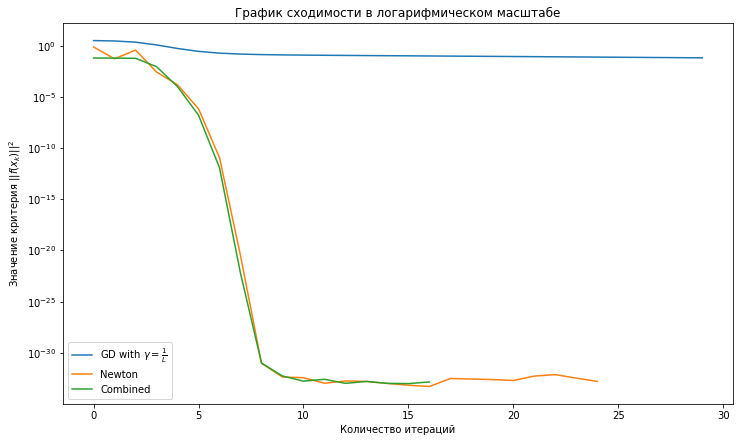

In [21]:
fig = plt.figure(figsize = (12, 7))
x_0 = np.random.randn(d)
lambd = L / 100
gamma = 1 / L
error_NT, _ = Newton(X, y, x_0, lambd)
error_GD, _ = GradientDescent(X, y, x_0, gamma, lambd, max_iter = 30)
error_C, _ = Combined(X, y, x_0, gamma, lambd, max_iter_GD = 2, max_iter_NT = 15)
plt.plot(range(len(error_GD)), error_GD, label = r'GD with $\gamma = \frac{1}{L}$')
plt.plot(range(len(error_NT)), error_NT, label = r'Newton')
plt.plot(range(len(error_C)), error_C, label = r'Combined')
plt.title("График сходимости в логарифмическом масштабе")
plt.xlabel("Количество итераций")
plt.ylabel(r"Значение критерия $||f(x_k)||^2$")
plt.yscale('log')
plt.legend()
plt.show()

Как видно из графиков, метод Ньютона сходится и без градиентного спуска вначале, но с ним совсем немножно лучше.

__(б)__ Для данной задачи реализуйте квазиньютоновские методы: Бройдена, DFP, BFGS (смотри Главу 6 из [книги](https://www.csie.ntu.edu.tw/~r97002/temp/num_optimization.pdf), а особенности реализации можно посмотреть [здесь](https://github.com/scipy/scipy/blob/v0.18.1/scipy/optimize/optimize.py#L874-L976)), L-BFGS (смотри [статью](http://users.iems.northwestern.edu/~nocedal/PDFfiles/limited-memory.pdf)). Решите с помощью них задачу регресии. Постйроте графики сходимости и изменения accuracy. Сделайте вывод.

Правило выбора шага:

In [41]:
def Wolf(x, grad, d):
    gamma = 1
    alpha = 0.8
    c1 = 0.01
    c2 = 0.9
    f = f_log(x, X, y)
    while not (f_log(x + gamma * d, X, y) <= f + c1 * gamma * np.dot(grad, d) and \
               np.abs((grad_f_log(x + gamma * d, X, y) + lambd * (x + gamma * d)).dot(d)) >= c2 * np.abs(grad.dot(d))): 
        gamma = gamma * alpha 
    return gamma

Метод Бройдена:

In [48]:
def Broyden(X, y, x_0, gamma, max_iter, rule):
    error = []
    x = x_0 
    H = hess_f_log(x, X, y) + lambd * np.eye(d)
    grad = grad_f_log(x, X, y) + lambd * x
    for _ in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        error.append(np.linalg.norm(grad) ** 2)
        
        dem = - H @ grad
        if rule == "Wolf":
            gamma = Wolf(x, grad, dem)
        else:
            gamma = rule
        x, x_prev = x + gamma * dem, x
        grad, grad_prev = grad_f_log(x, X, y) + lambd * x, grad
        s = x - x_prev
        y_t = grad - grad_prev
        q = s - H @ y_t
        mu = 1 / (q @ y_t)
        H = H + mu * np.array([q]).T @ np.array([q])
    return error, x

Метод DFP:

In [49]:
def DFP(X, y, x_0, gamma, max_iter, rule):
    error = []
    x = x_0 
    H = hess_f_log(x, X, y) + lambd * np.eye(d)
    grad = grad_f_log(x, X, y) + lambd * x
    
    for _ in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        error.append(np.linalg.norm(grad) ** 2)

        dem = - H @ grad
        if rule == "Wolf":
            gamma = Wolf(x, grad, dem)
        else:
            gamma = rule
        x, x_prev = x + gamma * dem, x
        grad, grad_prev = grad_f_log(x, X, y) + lambd * x, grad
        s = np.array([x - x_prev]).T
        y_t = np.array([grad - grad_prev]).T
        H = H - (H @ y_t @ y_t.T @ H) / (y_t.T @ H @ y_t) + s @ s.T / (y_t.T @ s)
    return error, x

Метод BFGS:

In [55]:
def BFGS(X, y, x_0, gamma, max_iter, rule):
    error = []
    x = x_0 
    H = hess_f_log(x, X, y) + lambd * np.eye(d)
    grad = grad_f_log(x, X, y) + lambd * x
    for _ in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        error.append(np.linalg.norm(grad) ** 2)
        
        dem = - H @ grad
        if rule == "Wolf":
            gamma = Wolf(x, grad, dem)
        else:
            gamma = rule
        
        x, x_prev = x + gamma * dem, x
        grad, grad_prev = grad_f_log(x, X, y) + lambd * x, grad
        s = np.array([x - x_prev]).T
        y_t = np.array([grad - grad_prev]).T
        rho = 1 / (y_t.T @ s)
        V = np.eye(d) - rho * y_t @ s.T
        H = V.T @ H @ V + rho * s @ s.T
    return error, x

Метод L-BFGS:

In [58]:
def LBFGS(X, y, x_0, gamma, m, max_iter, rule):
    error = []
    x = x_0 
    H0 = hess_f_log(x, X, y) + lambd * np.eye(d)
    H = H0
    grad = grad_f_log(x, X, y) + lambd * x
    ss = np.zeros((d, 3))
    ys = np.zeros((d, 3))
    for k in trange(max_iter, file = stdout, ncols = 80, colour = 'cyan'):
        error.append(np.linalg.norm(grad) ** 2)
        
        dem = - H @ grad
        if rule == "Wolf":
            gamma = Wolf(x, grad, dem)
        else:
            gamma = rule
        
        x, x_prev = x + gamma * dem, x
        grad, grad_prev = grad_f_log(x, X, y) + lambd * x, grad
        s = x - x_prev
        y_t = grad - grad_prev
        for i in range(m - 1):
            ss[ : , i] = ss[ : , i + 1]
            ys[ : , i] = ys[ : , i + 1]
        ss[ : , m - 1] = s
        ys[ : , m - 1] = y_t

        H = H0
        for i in range(max(0, m - k - 1), m):
            s = np.array([ss[ : , i ]]).T
            y_t = np.array([ys[ : , i ]]).T
            rho = 1 / (y_t.T @ s)
            V = np.eye(d) - rho * y_t @ s.T
            H = V.T @ H @ V + rho * s @ s.T
    return error, x

In [45]:
x_0 = np.random.randn(d)
lambd = L / 100
gamma = 1 / L
rule = 'Wolf'
m = 3
max_iter = 20

In [52]:
error_Broyden, _ = Broyden(X, y, x_0, gamma, max_iter, rule)

100%|███████████████████████████████████████████| 20/20 [00:29<00:00,  1.48s/it]


In [53]:
error_DFP, _ = DFP(X, y, x_0, gamma, max_iter, rule)

100%|███████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


In [56]:
error_BFGS, _ = BFGS(X, y, x_0, gamma, max_iter, rule)

100%|███████████████████████████████████████████| 20/20 [00:27<00:00,  1.40s/it]


In [59]:
error_L_BFGS, _ = LBFGS(X, y, x_0, gamma, m, max_iter, rule)

100%|███████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


In [60]:
error_GD, _ = GradientDescent(X, y, x_0, gamma, lambd, max_iter = max_iter)

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.49it/s]


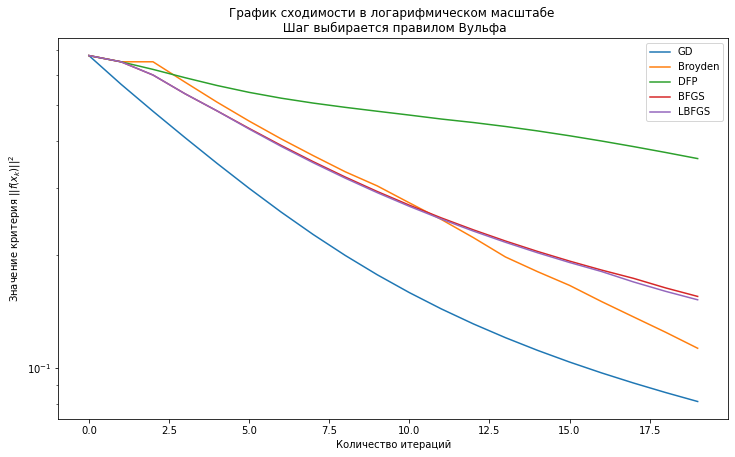

In [61]:
fig = plt.figure(figsize = (12, 7))

plt.plot(range(len(error_GD)), error_GD, label = r'GD')
plt.plot(range(len(error_Broyden)), error_Broyden, label = r'Broyden')
plt.plot(range(len(error_DFP)), error_DFP, label = r'DFP')
plt.plot(range(len(error_BFGS)), error_BFGS, label = r'BFGS')
plt.plot(range(len(error_L_BFGS)), error_L_BFGS, label = r'LBFGS')

plt.title("График сходимости в логарифмическом масштабе \n Шаг выбирается правилом Вульфа")
plt.xlabel("Количество итераций")
plt.ylabel(r"Значение критерия $||f(x_k)||^2$")
plt.yscale('log')
plt.legend()
plt.show()

Как видно из графиков, ничего особо градиентный спуск не побило, но давайте попробуем взять константный шаг:

In [62]:
error_Broyden, _ = Broyden(X, y, x_0, gamma, max_iter, 0.5)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  8.73it/s]


In [63]:
error_DFP, _ = DFP(X, y, x_0, gamma, max_iter, 0.5)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  8.66it/s]


In [64]:
error_BFGS, _ = BFGS(X, y, x_0, gamma, max_iter, 0.5)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.10it/s]


In [65]:
error_L_BFGS, _ = LBFGS(X, y, x_0, gamma, m, max_iter, 0.5)

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  7.47it/s]


In [66]:
error_GD, _ = GradientDescent(X, y, x_0, gamma, lambd, max_iter = max_iter)

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 12.54it/s]


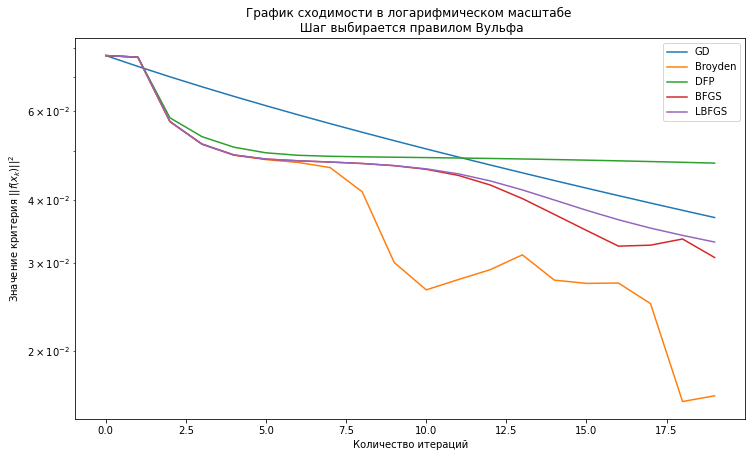

In [67]:
fig = plt.figure(figsize = (12, 7))

plt.plot(range(len(error_GD)), error_GD, label = r'GD')
plt.plot(range(len(error_Broyden)), error_Broyden, label = r'Broyden')
plt.plot(range(len(error_DFP)), error_DFP, label = r'DFP')
plt.plot(range(len(error_BFGS)), error_BFGS, label = r'BFGS')
plt.plot(range(len(error_L_BFGS)), error_L_BFGS, label = r'LBFGS')

plt.title("График сходимости в логарифмическом масштабе \n Шаг выбирается правилом Вульфа")
plt.xlabel("Количество итераций")
plt.ylabel(r"Значение критерия $||f(x_k)||^2$")
plt.yscale('log')
plt.legend()
plt.show()

Теперь почти все методы лучше и по времени, и по точности. Получается, иногда правильнее поподбирать решение, нежели чем пользоваться теоритическими соображениями.

__Бонусные пункты__

__(в)__ Реализуйте подход из [работы](https://pages.cs.wisc.edu/~swright/726/handouts/barzilai-borwein.pdf). С помощью них решите задачу регресии. Сравните их работу с квазиньютоновскими методами. Сделайте вывод.

In [16]:
#ответ

__(г)__ Реализуйте методы Newton-Learn и Cubic-Newton-Learn из [работы](https://proceedings.mlr.press/v139/islamov21a.html). С помощью них решите задачу регресии. Сравните их работу с квазиньютоновскими методами. Какой критерий сравнения будете использовать? 

In [17]:
#ответ